In [1]:
import pandas as pd
import wandb
import matplotlib.pyplot as plt

api = wandb.Api()
entity = "magalhaes"
project = "Audio"

runs = api.runs(f"{entity}/{project}")

In [2]:
summary_list, config_list, name_list = [], [], []
for run in runs:
    # .summary contains output keys/values for
    # metrics such as accuracy.
    #  We call ._json_dict to omit large files
    summary_list.append(run.summary._json_dict)

    # .config contains the hyperparameters.
    #  We remove special values that start with _.
    config_list.append(
        {k: v for k,v in run.config.items()
         if not k.startswith('_')})

    # .name is the human-readable name of the run.
    name_list.append(run.name)

summary_df = pd.DataFrame.from_records(summary_list)

summary_df['name'] = name_list

# FIlter summary_df to only include rows with "name" containing "MData" and NOT containing "split"
summary_df = summary_df[summary_df['name'].str.contains("MData") & ~summary_df['name'].str.contains("split")]

# Remove "Precomputed_Spec_MData_" from "name" column
summary_df['name'] = summary_df['name'].str.replace("Precomputed_Spec_MData_", "")

# Separate the "name" into "Augmentation" and "RunID" where the "name" is NameOfAugmentationRunID, but RunID is a number. Eg AddGaussianNoise0
summary_df[['Augmentation', 'RunID']] = summary_df['name'].str.split('(?<=\D)(?=\d)', expand=True)

# Remove the "name" column
summary_df = summary_df.drop(columns=['name'])

# Reduce columns to "Name", "Recall", "F1 score", "Precision", "Accuracy"
summary_df = summary_df[["Augmentation", "RunID", "F1 score", "Recall", "Precision", "Accuracy"]]

# Sort by augmentation
summary_df = summary_df.sort_values(by=['Augmentation'], ascending=False)

# Sort by augmentation, then by f1-score
# summary_df = summary_df.sort_values(by=['Augmentation', 'F1 score'], ascending=False)

# Rename f1 score to F1Score
summary_df = summary_df.rename(columns={"F1 score": "F1-Score"})

# Remove the ids
summary_df = summary_df.reset_index(drop=True)

summary_df

,Augmentation,RunID,F1-Score,Recall,Precision,Accuracy
0,TimeStretch,0,0.534976,0.785290,0.454625,0.808767
1,TimeStretch,2,0.533716,0.782784,0.455627,0.812435
2,TimeStretch,3,0.537989,0.788765,0.460770,0.803353
3,TimeStretch,1,0.520698,0.779298,0.447048,0.807370
4,TimeMasking,5,0.535160,0.761252,0.460053,0.812491
5,TimeMasking,0,0.536913,0.806126,0.459757,0.813331
6,TimeMasking,1,0.546711,0.766989,0.468955,0.803893
7,TimeMasking,2,0.520301,0.730317,0.447022,0.807664
8,TimeMasking,4,0.527731,0.743111,0.456606,0.808866
9,TimeMasking,6,0.548712,0.739483,0.473477,0.810188


/tmp/ipykernel_19600/418527824.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap("tab10", len(df["RunID"].unique()))  # Use a different colormap


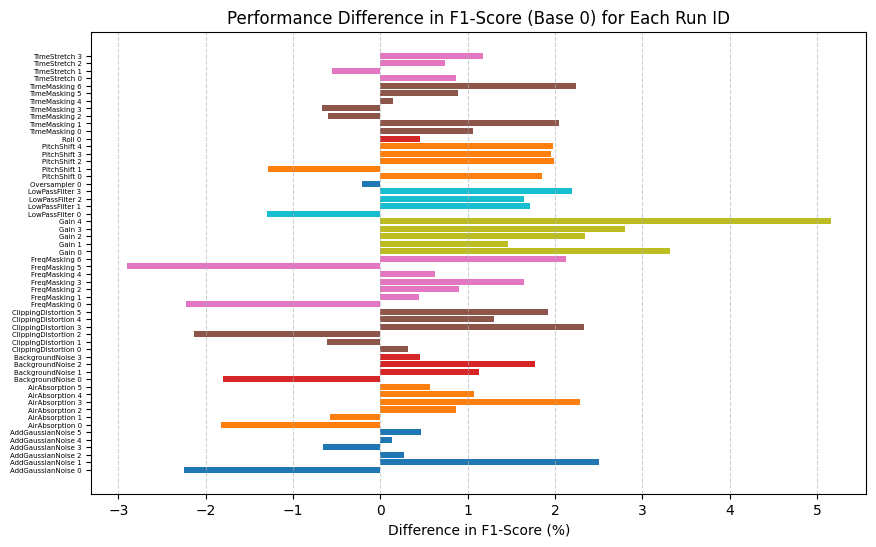

In [5]:
df = summary_df

# Calculate the difference in F1-Score compared to Base 0
base_f1_score = df[df["Augmentation"] == "Base"]["F1-Score"].values[0]
df["Difference"] = (df["F1-Score"] - base_f1_score) * 100

# Filter out rows with NaN values in the F1-Score
df = df[(df["Augmentation"] != "Base") & ~df["F1-Score"].isna()]

# Create a horizontal bar chart for each augmentation type
plt.figure(figsize=(10, 6))
colors = plt.cm.get_cmap("tab10", len(df["RunID"].unique()))  # Use a different colormap

# Sort them alphabetically, then by runid
df = df.sort_values(by=["Augmentation", "RunID"])

for i, (augmentation, group) in enumerate(df.groupby("Augmentation")):
    color = colors(i % len(df["RunID"].unique()))  # Cycle through colors
    plt.barh([augmentation + f" {run_id}" for run_id in group["RunID"]], group["Difference"], color=color, label=augmentation)

# Lower the y-axis label font size
plt.yticks(fontsize=5)

plt.xlabel('Difference in F1-Score (%)')
plt.title('Performance Difference in F1-Score (Base 0) for Each Run ID')
plt.grid(axis='x', linestyle='--', alpha=0.6)
# plt.legend()

plt.show()

In [7]:
#Get the 5 best performing augmentations, one per type
best_augmentations = []
for augmentation, group in df.groupby("Augmentation"):
    best_augmentations.append(group.sort_values(by="Difference", ascending=False).iloc[0])

# SOrt by difference
best_augmentations = sorted(best_augmentations, key=lambda x: x["Difference"], reverse=True)

# Print the best augmentations
print("Best augmentations:")
for augmentation in best_augmentations:
    print(f"{augmentation['Augmentation']} {augmentation['RunID']} with a difference of {augmentation['Difference']}%")

Best augmentations:
Gain 4 with a difference of 5.160843699756801%
AddGaussianNoise 1 with a difference of 2.506085194687846%
ClippingDistortion 3 with a difference of 2.3334264321642317%
AirAbsorption 3 with a difference of 2.2873365978253846%
TimeMasking 6 with a difference of 2.2424850913214778%
LowPassFilter 3 with a difference of 2.1993426401693106%
FreqMasking 6 with a difference of 2.1305738229694615%
PitchShift 2 with a difference of 1.985855575238371%
BackgroundNoise 2 with a difference of 1.772278454480114%
TimeStretch 3 with a difference of 1.1701462529476236%
Roll 0 with a difference of 0.44792819803091133%
Oversampler 0 with a difference of -0.21251436091236364%
